In [1]:
from Neuron_analysis_tool.load import Analyzer, long_pulse_protocol
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


In [2]:

def Rin_func(seg):
    imp = h.Impedance(seg.x, sec=seg.sec)
    imp.loc(seg.x, sec=seg.sec)
    imp.compute(0, 1)
    return imp.input(seg.x, sec=seg.sec)


In [3]:

dir_path = os.path.abspath('')
morph_path=os.path.join(dir_path,'data/morph.ASC')

analyser = Analyzer(type='ASC', morph_path=morph_path)


open_morph:  /ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/data/morph.ASC

17089 lines read

/ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/data/morph.ASC problems


Main branch starting at line 305 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 3635 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 29292.46it/s]


<AxesSubplot:>

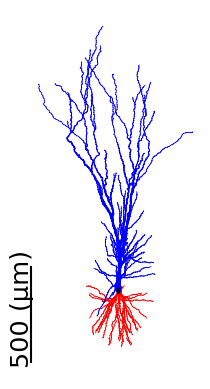

In [4]:
analyser.plot_morph(scale=500, diam_factor=0.5, theta=-75)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 29546.25it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

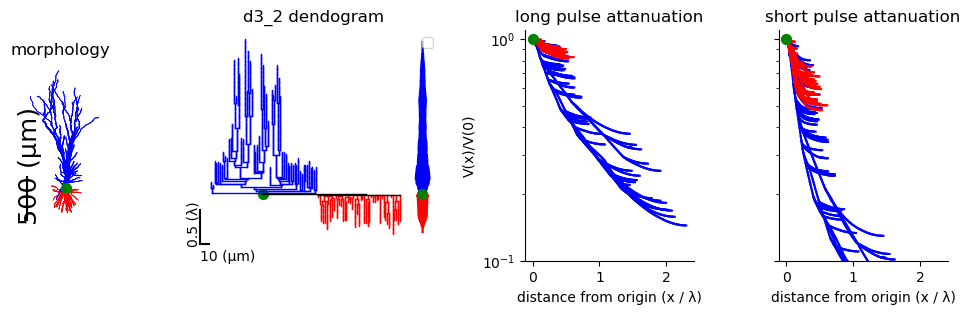

In [5]:
analyser.create_card(theta=-75, diam_factor=0.5)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 29854.40it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

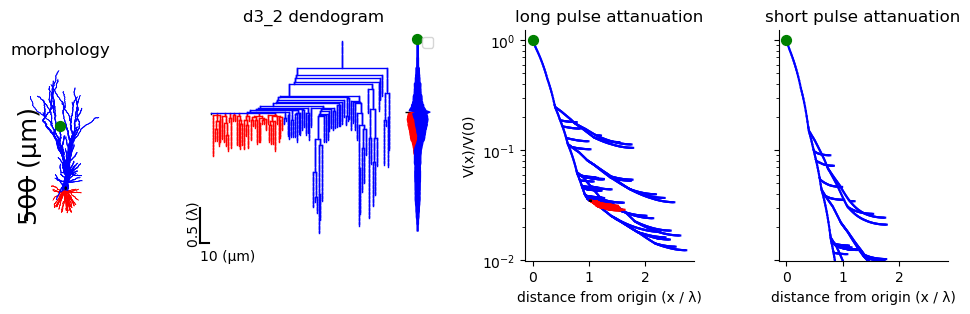

In [6]:
analyser.create_card(start_seg=list(analyser.cell.apic[101])[-1], theta=-75, diam_factor=0.5)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 10938.97it/s]


Text(0, 0.5, 'Rin (M ohm)')

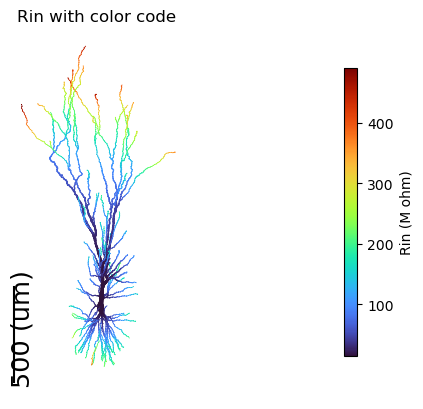

In [7]:
plt.title('Rin with color code')
analyser.plot_morph_with_value_func(func = Rin_func, run_time=1000, theta=-75, scale=500, diam_factor=0.5)
plt.ylabel('Rin (M ohm)')


optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 33652.33it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


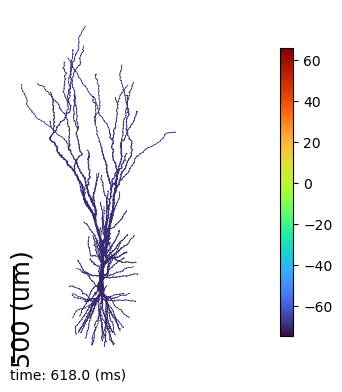

In [4]:
record_dict, time = analyser.record_protocol(cut_start_ms=1000.0, record_name='v')
animation = analyser.create_movie_from_rec(record_dict=record_dict, time=time, fps=10, clip_name='L5PC_V_spikes', threads=4, slow_down_factor=50, func_for_missing_frames=np.max, theta=-75, diam_factor=0.5)
animation.ipython_display(fps=10, loop=True, autoplay=True)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 32731.08it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


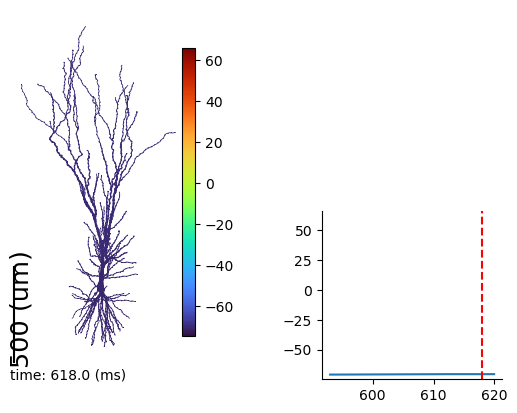

In [5]:
show_records_from = [list(analyser.cell.soma[0])[0]]

record_dict, time = analyser.record_protocol(cut_start_ms=1000.0, record_name='v')
animation = analyser.create_movie_from_rec(record_dict=record_dict, time=time, fps=10, clip_name='L5PC_V_spikes', threads=4, slow_down_factor=50, func_for_missing_frames=np.max, theta=-75, diam_factor=0.5, show_records_from=show_records_from)
animation.ipython_display(fps=10, loop=True, autoplay=True)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 26249.49it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


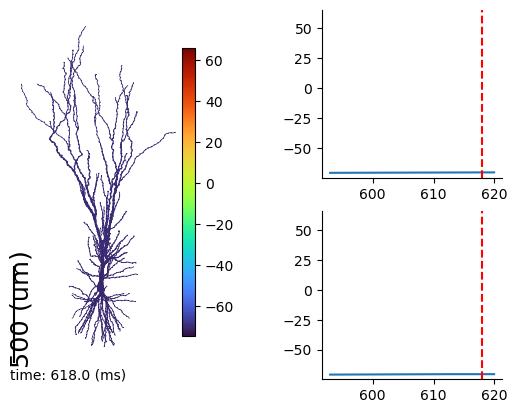

In [6]:
show_records_from = [list(analyser.cell.soma[0])[0], list(analyser.cell.apic[40])[0]]

record_dict, time = analyser.record_protocol(cut_start_ms=1000.0, record_name='v')
animation = analyser.create_movie_from_rec(record_dict=record_dict, time=time, fps=10, clip_name='L5PC_V_spikes', threads=4, slow_down_factor=50, func_for_missing_frames=np.max, theta=-75, diam_factor=0.5, show_records_from=show_records_from)
animation.ipython_display(fps=10, loop=True, autoplay=True)